In [1]:
# Importing Dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sys
import os
import warnings
from datetime import datetime
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import lightgbm as lgb
from xgboost import XGBClassifier
from pai4sk import BoostingMachine

In [2]:
input_path = r"Pokemon.csv"
data = pd.read_csv(input_path)

In [3]:
# Checking Basic information available from dataset
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    object
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(4)
memory usage: 75.9+ KB


In [4]:
data[['HP', 'Attack', 'Defense']].head()
data[['HP', 'Attack', 'Defense']].describe()

,HP,Attack,Defense
count,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500
std,25.534669,32.457366,31.183501
min,1.000000,5.000000,5.000000
25%,50.000000,55.000000,50.000000
50%,65.000000,75.000000,70.000000
75%,80.000000,100.000000,90.000000
max,255.000000,190.000000,230.000000


In [5]:
# Isolated table of Attack and Defense features
atk_def = data[['Attack', 'Defense']]
atk_def.head()

,Attack,Defense
0,49,49
1,62,63
2,82,83
3,100,123
4,52,43


In [6]:
# Figuring out the polynomial features and performing the transformation
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
res = pf.fit_transform(atk_def)
res

array([[   49.,    49.,  2401.,  2401.,  2401.],
       [   62.,    63.,  3844.,  3906.,  3969.],
       [   82.,    83.,  6724.,  6806.,  6889.],
       ...,
       [  110.,    60., 12100.,  6600.,  3600.],
       [  160.,    60., 25600.,  9600.,  3600.],
       [  110.,   120., 12100., 13200., 14400.]])

In [7]:
# New dataframe with polynomial features included
pd.DataFrame(pf.powers_, columns=['Attack_degree', 'Defense_degree'])
intr_features = pd.DataFrame(res, columns=['Attack_1', 'Defense_1', 'Attack^2', 'Attack x Defense', 'Defense^2'])
#intr_features.drop(['Attack','Defense'],axis=1,inplace = True)
data = pd.concat([data,intr_features],axis=1)
intr_features.head(5)

,Attack_1,Defense_1,Attack^2,Attack x Defense,Defense^2
0,49.0,49.0,2401.0,2401.0,2401.0
1,62.0,63.0,3844.0,3906.0,3969.0
2,82.0,83.0,6724.0,6806.0,6889.0
3,100.0,123.0,10000.0,12300.0,15129.0
4,52.0,43.0,2704.0,2236.0,1849.0


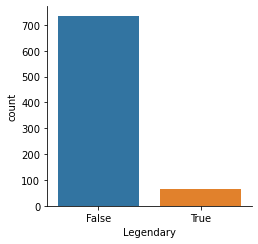

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
# Ground Truth Values of whether a pokemon is legendary or not
sns.factorplot('Legendary',data=data,kind='count',size = 3.5)

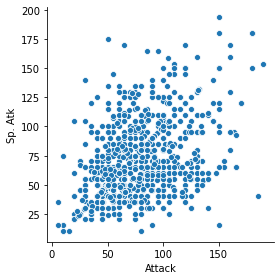

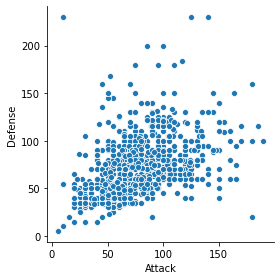

In [9]:
sns.relplot(x = "Attack",y = "Sp. Atk",data = data,height = 4,aspect = 1)
sns.relplot(x = "Attack",y = "Defense",data = data,height = 4,aspect = 1)

In [10]:
print(data.isnull().sum())
# There are 386 Null values within the data, and are only in column "Type 2"

#                     0
Name                  0
Type 1                0
Type 2              386
Total                 0
HP                    0
Attack                0
Defense               0
Sp. Atk               0
Sp. Def               0
Speed                 0
Generation            0
Legendary             0
Attack_1              0
Defense_1             0
Attack^2              0
Attack x Defense      0
Defense^2             0
dtype: int64


In [11]:
# Populating The Null values with the statistical mode 

data['Type 2'].loc[(data['Type 2'].isnull())] = data['Type 2'].mode().max()
print(data['Type 2'].head(12))


0     Poison
1     Poison
2     Poison
3     Poison
4     Flying
5     Flying
6     Flying
7     Dragon
8     Flying
9     Flying
10    Flying
11    Flying
Name: Type 2, dtype: object


In [12]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['Type 1'] = LE.fit_transform(data['Type 1'])
data['Type 2'] = LE.fit_transform(data['Type 2'])
data['Generation'] = LE.fit_transform(data['Generation'])
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Attack_1,Defense_1,Attack^2,Attack x Defense,Defense^2
0,1,Bulbasaur,9,13,318,45,49,49,65,65,45,0,False,49.0,49.0,2401.0,2401.0,2401.0
1,2,Ivysaur,9,13,405,60,62,63,80,80,60,0,False,62.0,63.0,3844.0,3906.0,3969.0
2,3,Venusaur,9,13,525,80,82,83,100,100,80,0,False,82.0,83.0,6724.0,6806.0,6889.0
3,3,VenusaurMega Venusaur,9,13,625,80,100,123,122,120,80,0,False,100.0,123.0,10000.0,12300.0,15129.0
4,4,Charmander,6,7,309,39,52,43,60,50,65,0,False,52.0,43.0,2704.0,2236.0,1849.0


In [13]:
train,test = train_test_split(data,test_size = 0.3,shuffle = True)
train_x,train_y = train[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation','Attack_1','Defense_1','Attack^2','Attack x Defense','Defense^2']],train["Legendary"]
test_x,test_y = test[['Type 1','Type 2','Total','HP','Attack','Defense','Sp. Atk', 'Sp. Def','Speed','Generation','Attack_1','Defense_1','Attack^2','Attack x Defense','Defense^2']],test["Legendary"]

In [14]:
lgb_hps = { 'num_leaves': hp.choice('num_leaves',np.arange(100, 200, 10, dtype=int)),
            'max_depth': hp.choice('max_depth',np.arange(5, 16, 1, dtype=int)),
            'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
            'lambda_l1': hp.uniform('lambda_l1', 0, 10),
            'lambda_l2': hp.uniform('lambda_l2', 0, 10)
          }

num_leaves_list = [100,110,120,130,140,150,160,170,180,190,200]

In [15]:
accuracy_list_lgbm = []
def HPO_lgbm(lgb_hps):
    num_round = 50
    train_data=lgb.Dataset(train_x,label=train_y)
    lgbm=lgb.train(lgb_hps,train_data,num_round)
    ypred2=lgbm.predict(test_x)
    accuracy_lgbm = roc_auc_score(test_y,ypred2).mean()
    accuracy_list_lgbm.append(accuracy_lgbm)
    return {'loss': -accuracy_lgbm, 'status': STATUS_OK }

In [16]:
trials = Trials()
best_lgbm = fmin(fn= HPO_lgbm,
            space= lgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_lgbm = max(accuracy_list_lgbm)
print("Best Hyperparameters for LGBM are: \n")
best_lgbm

100%|██████████| 80/80 [00:03<00:00, 20.16trial/s, best loss: -0.9922422422422421]
Best Hyperparameters for LGBM are: 



{'bagging_fraction': 0.7678659364839354,
 'feature_fraction': 0.9742547350992281,
 'lambda_l1': 1.5927201448165116,
 'lambda_l2': 6.68402436736711,
 'learning_rate': 0.09692831421536507,
 'max_depth': 7,
 'num_leaves': 6}

Best num_leaves   =   6
Best max_depth   =   7
Best feature_fraction   =   0.9742547350992281
Best bagging_fraction   =   0.7678659364839354
Best learning_rate   =   0.09692831421536507
Best lambda_l1   =   1.5927201448165116
Best lambda_l2   =   6.68402436736711


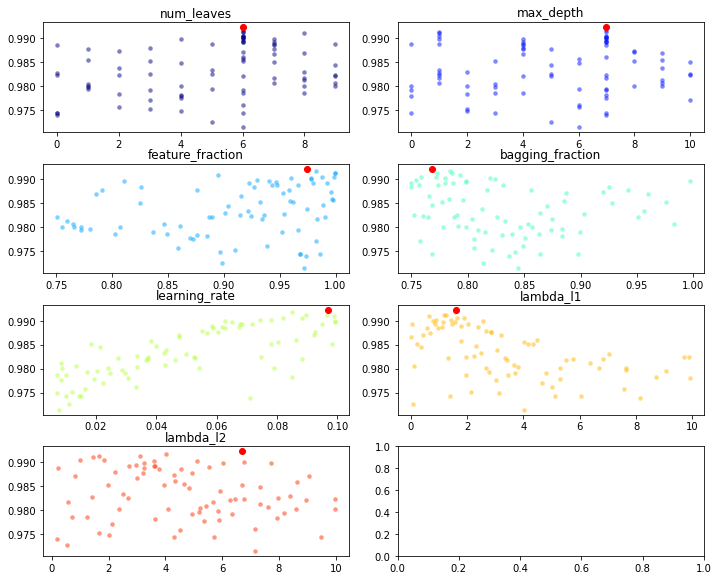

In [17]:
parameters = ['num_leaves','max_depth','feature_fraction','bagging_fraction','learning_rate','lambda_l1','lambda_l2']
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print("Best " + str(val) + "   =   " + str(best_lgbm[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_lgbm[val],max_acc_lgbm,color = "red")
    axes[i//2,i%2].set_title(val)

In [18]:
params = { 
            'num_leaves': num_leaves_list[best_lgbm['num_leaves']],
            'max_depth': best_lgbm['max_depth'],
#             'n_estimators': best_lgbm['n_estimators'],
            'feature_fraction':best_lgbm['feature_fraction'],
            'bagging_fraction':best_lgbm['bagging_fraction'],
            'learning_rate':best_lgbm['learning_rate'],
            'lambda_l1': best_lgbm['lambda_l1'],
            'lambda_l2':best_lgbm['lambda_l2']
          }
train_data=lgb.Dataset(train_x,label=train_y)

num_round=100
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(test_x)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,test_y),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  97.083 %
Execution time =  0:00:00.065660
Prediction time =  0:00:00.003086


In [19]:
xgb_hps = {  
            'learning_rate':     hp.loguniform('learning_rate', -5.0, -2.3),
            'max_depth':         hp.choice('max_depth',np.arange(5,16,1,dtype = int)),
            'lambda':            hp.quniform('lambda',2, 16, 1),
            'subsample':        hp.quniform('subsample',0.1,1.0,0.1),
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'min_split_loss' : hp.quniform('min_split_loss',0.1,2.0,0.1)
        }

depth_list = [i for i in range(5,16,1)]

In [20]:
accuracy_list_xgb = []
def HPO_xgb(xgb_hps):
    model = model = XGBClassifier(**xgb_hps)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    accuracy_xgb = accuracy_score(y_pred,test_y).mean()
    accuracy_list_xgb.append(accuracy_xgb)
    return {'loss': -accuracy_xgb, 'status': STATUS_OK }

In [21]:
trials = Trials()
best_xgb = fmin(fn= HPO_xgb,
            space= xgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_xgb = max(accuracy_list_xgb)
print("Best Hyperparameters for XGBoost are: \n")
best_xgb

100%|██████████| 80/80 [00:07<00:00, 11.17trial/s, best loss: -0.9833333333333333]
Best Hyperparameters for XGBoost are: 



{'colsample_bytree': 0.8,
 'lambda': 13.0,
 'learning_rate': 0.029001064148423253,
 'max_depth': 5,
 'min_split_loss': 0.4,
 'subsample': 0.5}

Best max_depth   =   10
Best subsample   =   0.5
Best learning_rate   =   0.029001064148423253
Best min_split_loss   =   0.4
Best lambda   =   13.0
Best colsample_bytree   =   0.8


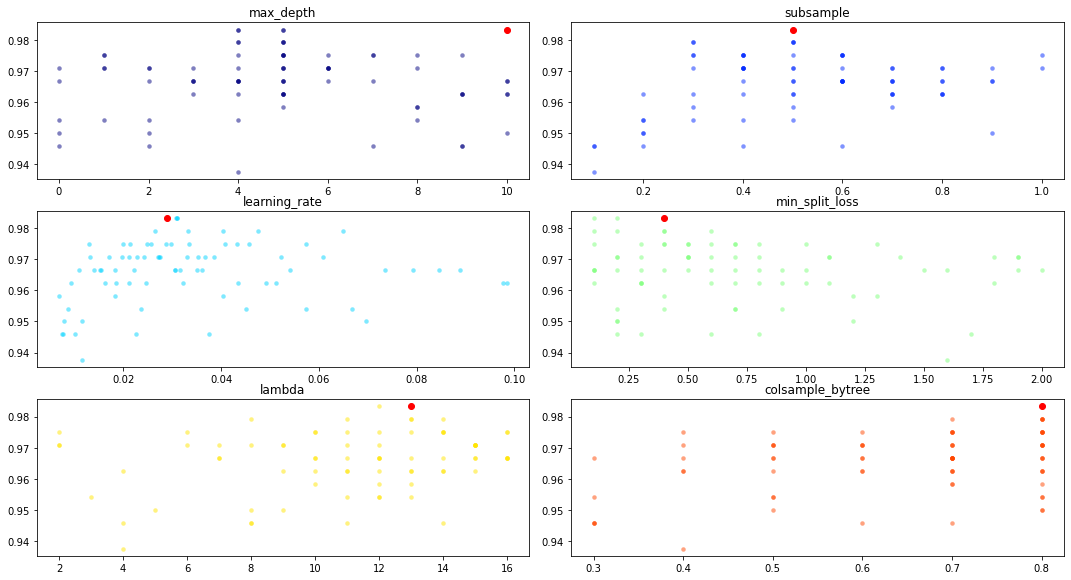

In [22]:
parameters = ['max_depth','subsample','learning_rate','min_split_loss','lambda','colsample_bytree']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'max_depth':
        best_xgb[val] = depth_list[best_xgb[val]]
    print("Best " + str(val) + "   =   " + str(best_xgb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_xgb[val],max_acc_xgb,color = "red")
    axes[i//2,i%2].set_title(val)

In [23]:
model = XGBClassifier(**best_xgb)
t1=datetime.now()
model.fit(train_x,train_y)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,test_y),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  98.333 %
Execution time =  0:00:00.059254
Prediction time =  0:00:00.001693


In [24]:
num_threads = 25
sb_hps = {
            'objective': 'logloss',
#             'num_round': hp.uniform('num_round', 10, 700, 1),
            'min_max_depth':hp.choice('min_max_depth',np.arange(1,6,1,dtype = int)), 
            'max_max_depth':hp.choice('max_max_depth',np.arange(6,10,1,dtype = int)),
            'learning_rate':hp.loguniform('learning_rate', -5.0, -2.3), 
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'lambda_l2':hp.quniform('lambda_l2',2, 16, 1),
            'subsample':hp.quniform('subsample',0.3, 1.0, 0.1),
            'hist_nbins': 10,
            'random_state':42, 
            'n_threads':num_threads
}
depth_list_min = [i for i in range(1,6,1)]
depth_list_max = [i for i in range(6,10,1)]

In [25]:
accuracy_list_sb = []
def HPO_sb(sb_hps):
    model = model = BoostingMachine(**sb_hps)
    model.fit(train_x.to_numpy(),train_y.to_numpy())
    y_pred = model.predict(np.ascontiguousarray(test_x))
    accuracy_sb = accuracy_score(y_pred.round(),np.ascontiguousarray(test_y)).mean()
    accuracy_list_sb.append(accuracy_sb)
    return {'loss': -accuracy_sb, 'status': STATUS_OK }

In [26]:
trials = Trials()
best_sb = fmin(fn= HPO_sb,
            space= sb_hps,
            algo= tpe.suggest,
            max_evals = 180,
            trials = trials
            )
max_acc_sb = max(accuracy_list_sb)
print("Best Hyperparameters for SnapBoost are: \n")
best_sb

100%|██████████| 180/180 [00:15<00:00, 11.29trial/s, best loss: -0.925]
Best Hyperparameters for SnapBoost are: 



{'colsample_bytree': 0.4,
 'lambda_l2': 13.0,
 'learning_rate': 0.008614188756800971,
 'max_max_depth': 3,
 'min_max_depth': 3,
 'subsample': 1.0}

Best min_max_depth   =   4
Best max_max_depth   =   9
Best learning_rate   =   0.008614188756800971
Best colsample_bytree   =   0.4
Best lambda_l2   =   13.0
Best subsample   =   1.0


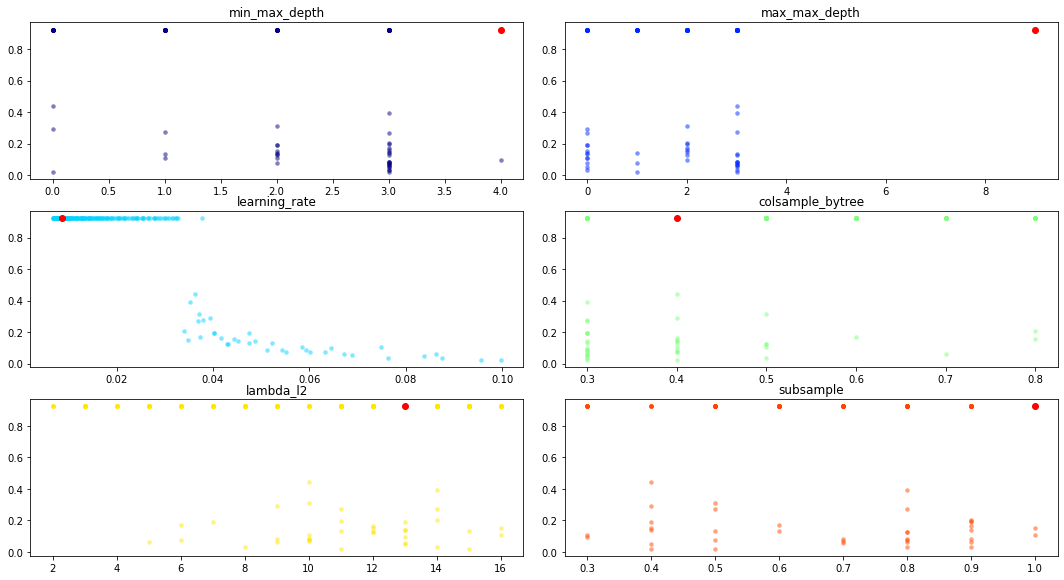

In [27]:
parameters = ['min_max_depth','max_max_depth','learning_rate','colsample_bytree','lambda_l2','subsample']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'min_max_depth' :
        best_sb[val] = depth_list_min[best_sb[val]]
    if val == 'max_max_depth':
        best_sb[val] = depth_list_max[best_sb[val]]
    print("Best " + str(val) + "   =   " + str(best_sb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_sb[val],max_acc_sb,color = "red")
    axes[i//2,i%2].set_title(val)

In [28]:
max_max_depth = 6
min_max_depth = 6
num_round = 60
learning_rate = 0.1
num_threads = 25
booster = BoostingMachine(**best_sb)
t1=datetime.now()
booster.fit(train_x.to_numpy(), train_y.to_numpy())
t2=datetime.now()
execution_time_snap_boost = t2-t1
t3 = datetime.now()
ypred = booster.predict(np.ascontiguousarray(test_x))
t4 = datetime.now()
accuracy_snap_boost = round(roc_auc_score(np.ascontiguousarray(test_y),ypred),2)
print("Accuracy score = ",accuracy_snap_boost*100,"%")
print("Execution time = ",execution_time_snap_boost)
print("Prediction time = ",t4-t3)
snap_boost_train_time = t2-t1

Accuracy score =  98.0 %
Execution time =  0:00:00.013470
Prediction time =  0:00:00.000599


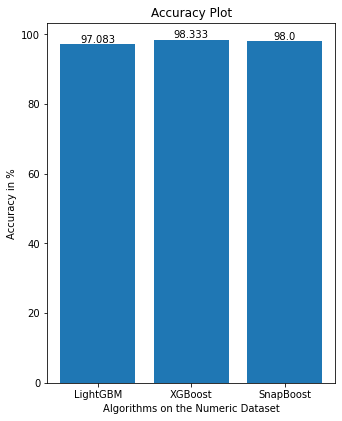

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

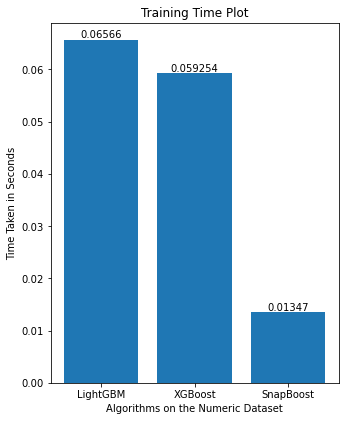

In [30]:
lg = float(str(lgbm_train_time)[5:])
sb = float(str(snap_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
training_time = [lg,xgb,sb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()